### Norm Based Metrics

WeightWatcher also provides average norm-based metrics.

You can think of these as Product Norm measure of the model complexity $\mathcal{C}$

$$\mathcal{C}:=\Vert\mathbf{W}_{1}\Vert_{\circ}\Vert\mathbf{W}_{2}\Vert_{\circ}\cdots\Vert\mathbf{W}_{L}\Vert_{\circ}$$

computed as an average over all layers (L),in log-units


$$\log_{10}\mathcal{C}\sim\langle\log_{10}\Vert\mathbf{W}\Vert_{\circ}\rangle:=\dfrac{1}{L}\sum\log_{10}\Vert\mathbf{W}\Vert_{\circ}$$

We need to take an average, not a direct sum, otherwise our metric will spuriously depend on the depth of the network.

WeightWatcher computes norm-metrics for each layer, and then reports the average log norm in the summary. These norm metrics include:

- the Frobenus Norm, or total mass of the weight matrix

 $$\Vert\mathbf{W}\Vert_{F}^{2}=(\sum_{i,j} W_{i,j}^{2})$$
 
 Note that this is related to the sum of the eigenvalues $\lambda_{i}$ of the correlation matrix $\mathbf{X}=\mathbf{W}^{T}\mathbf{W}$
 
 $$\text{norm}:=\Vert\mathbf{W}\Vert^{2}_{F}=\sum_{i}\lambda_{i}$$


 
- the Spectral Norm, or the largest eigenvalue $\lambda_{max}$ of the correlation matrix $\mathbf{X}$

 $$\text{spectralnorm}:=\Vert\mathbf{W}\Vert_{2}^{2}=\lambda_{max}$$



- the $\alpha$-Shatten Norm, defined by the Power Law fit of the tail of the ESD of $\mathbf{X}$

 $$\text{pnorm}:=\Vert\mathbf{W}\Vert_{2\alpha}^{2\alpha}=\sum_{i} \lambda_{i}^{\alpha_{i}}$$



- the $\hat{\alpha}$ metric, which is a weighted average of $\alpha$, weighted by the Spectral Norm  of each layer (which approximates the $\alpha$-Shattem Norm)


 $$\text{alpha_weighted}:=\sum_{i}\alpha_{i}\log_{10}\lambda_{i}$$
 

**Comments:** Unlike $\alpha$, these Norm-Based metrics are not scale invariant.  
  

#### Results on the Task 1  models

In [1]:
import numpy as np
import pandas as pd
import json, glob, re

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats

from scipy.stats import kendalltau, spearmanr

import import_ipynb
import Utils as U

import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

%load_ext watermark
%watermark

importing Jupyter notebook from Utils.ipynb


2021-05-27T12:53:48-07:00

CPython 3.8.5
IPython 7.18.1

compiler   : Clang 10.0.0 
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


In [2]:
test_accuracies, train_accuracies = U.read_accuracies()

In [3]:
rcParams['figure.figsize'] = 15,10
rcParams.update({'font.size': 16})



def plot_model_details(this_task, all_details):
    errors = {}
    mids = set([100*U.model_num(k) for k in all_details.keys()])

    for mid in mids:

        fig, axes = plt.subplots(2,3)
        subplts = axes.flatten()[::-1].tolist()
        model_num = U.model_num(mid)
        fig.suptitle("{} {}xx models: Average Metric vs. Test Accuracies".format(this_task, model_num))
        fig.tight_layout(pad=5.0)


        errors[mid] = {}
        for metric in ['lognorm', 'alpha', 'alpha_weighted', 'logspectralnorm', 'logpnorm', 'D']:#'softrank', 'D']:
            errors[mid][metric] = {}
            x, y = [], []
            subplt = subplts.pop()

            for model, details in all_details.items():
                # remove first and last layers / min_size = 20 really
                details = details[details['N']> 10]
                details = details[details['M']> 10]

                yval = details[metric].dropna().mean()

                if yval < 8:
                    this_mid = model.replace("model_", '')
                    test_accuracy = test_accuracies[this_task][int(this_mid)]

                    if int(this_mid) > mid and int(this_mid) < mid+100 :
                        x.append(test_accuracy)
                        y.append(yval)
                        color = U.mid_color(this_task, mid)
                        shape = U.mid_shape(this_task, mid)
                        subplt.scatter(test_accuracy, yval, color=color, marker=shape)


            if len(x)>0:
                x = np.array(x).reshape(-1,1)
                y = np.array(y).reshape(-1,1)
                regr = linear_model.LinearRegression()
                regr.fit(x, y)
                y_pred = regr.predict(x)
                subplt.plot(x, y_pred, color='teal', linewidth=1)

                #Table 4
                R2 = r2_score(y, y_pred)
                MSE = mean_squared_error(y, y_pred)
                MAE = mean_absolute_error(y, y_pred)

                errors[mid][metric]['MSE'] = MSE
                errors[mid][metric]['MAE'] = MAE
                errors[mid][metric]['R2'] = R2

                tau, p_value = stats.kendalltau(x, y)
                errors[mid][metric]['kendal_tau']= tau
                errors[mid][metric]['kendal_p_value']= p_value


                spman, p_value = spearmanr(x, y)
                errors[mid][metric]['spearman_tau']= spman
                errors[mid][metric]['spearman_p_value']= p_value  

                metname = U.metric_name(metric) 
                meteqn = U.metric_eqn(metric)

                title = metname +"\n"+r"$R^2$ {:0.2} $\tau$ {:0.2} SP {:0.2}".format(R2, tau, spman)
                subplt.set_title(title)
                
                rcParams.update({'font.size': 10})
                subplt.set_xlabel("Test Accuracy")
                subplt.set_xlabel("Avg {} {}".format(metname, meteqn))
                rcParams.update({'font.size': 16})

        
    return errors

#### Task1 and Task 2 Model Group Results

From these results, we see that 

- the average log Frobenius Norm is mostly correlated with the test accuracy $\Delta(\theta)$, but not always
- the average log Spectral Norm is strongly anti-correlated with $\Delta(\theta)$, but not always

- the $\alpha$ metric is always correlated with $\Delta(\theta)$, and while it is not always the strongest correaltion, it is the most consistent

Moreover, 

-in about half the cases, the quality of the $\alpha$ PL fit itself, the KS-Distance $D$ metric, is correlated with  $\Delta(\theta)$.




#### Task1 Model Group Plots


Read 96 details dataframes for task1_v4


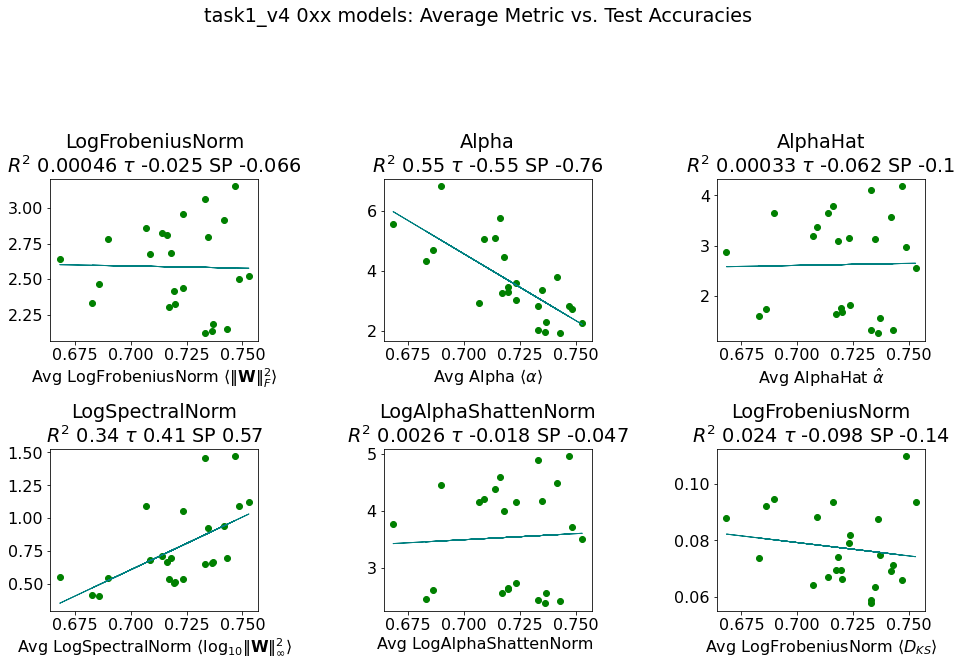

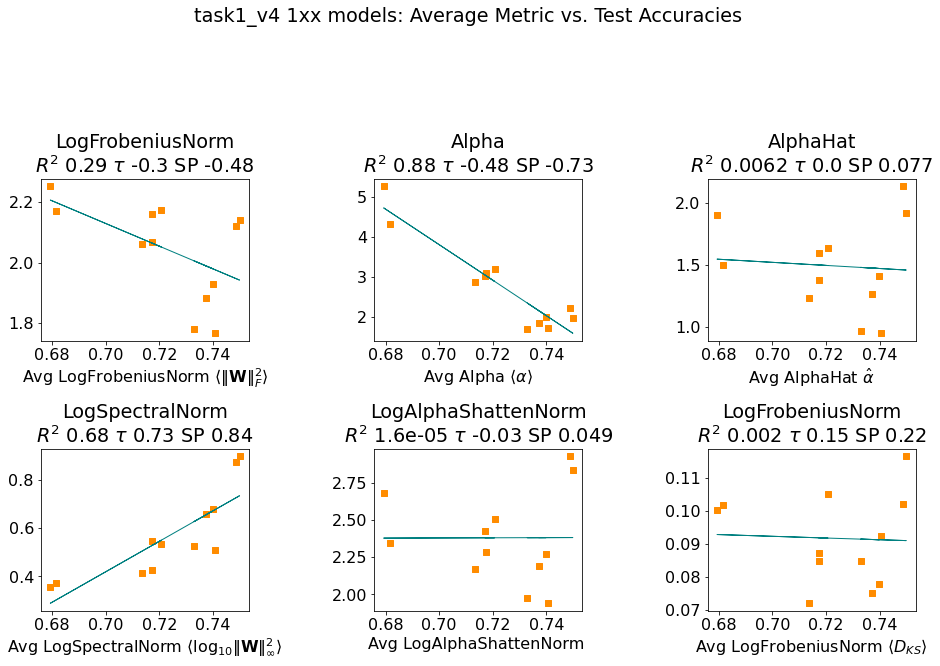

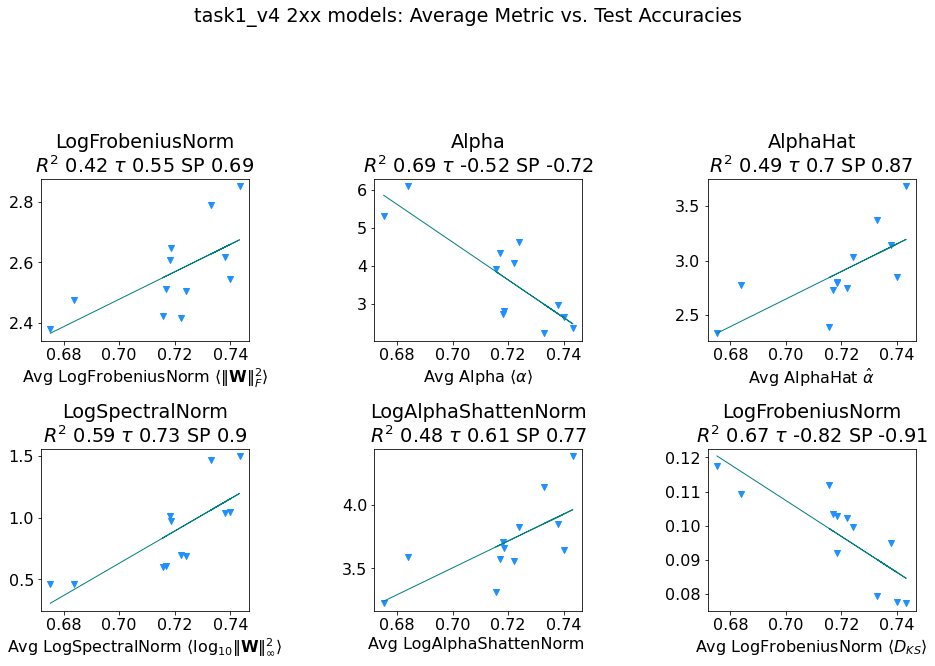

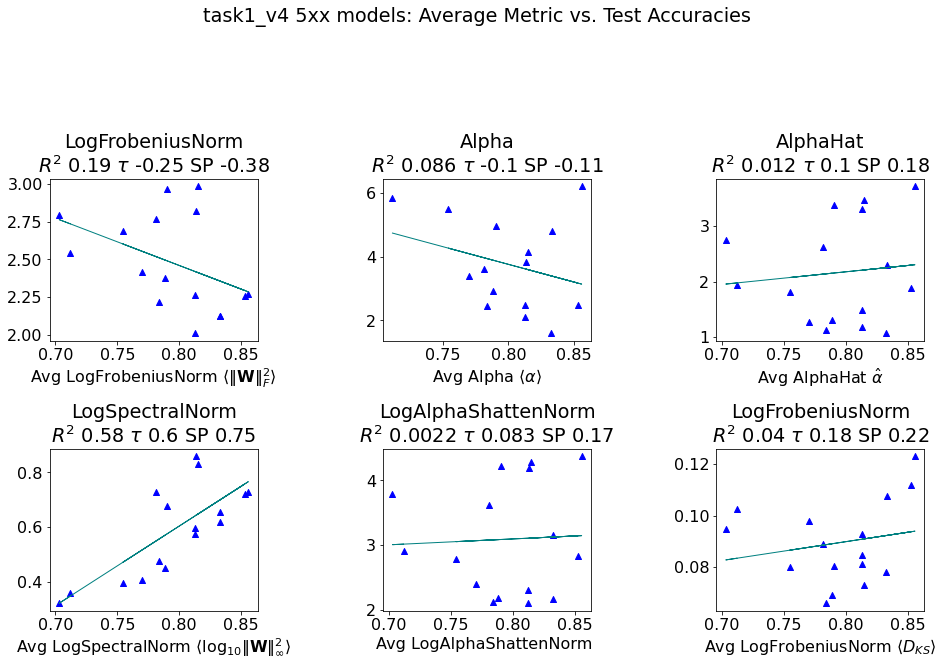

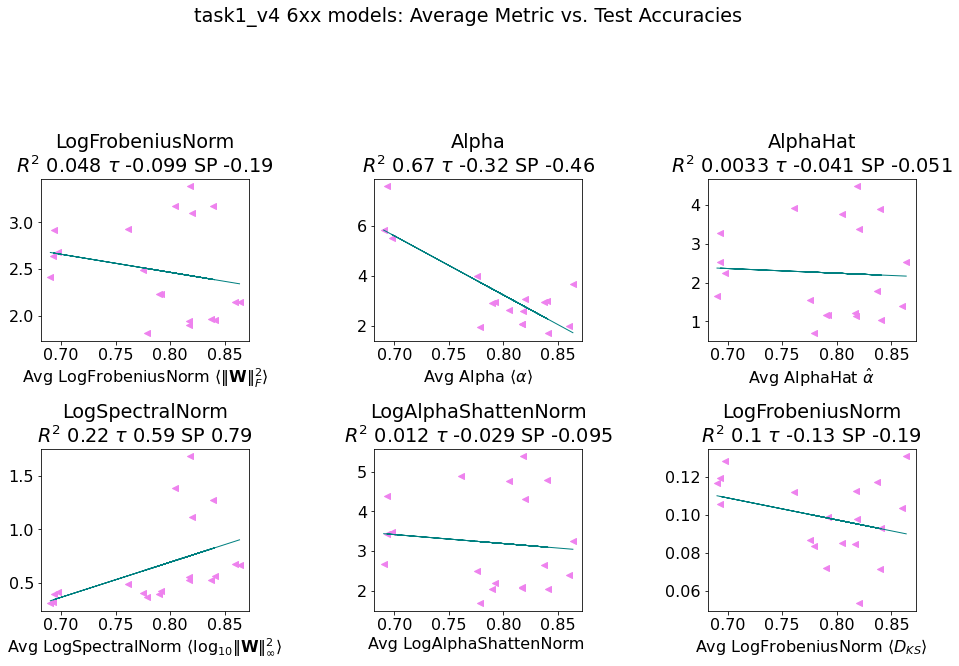

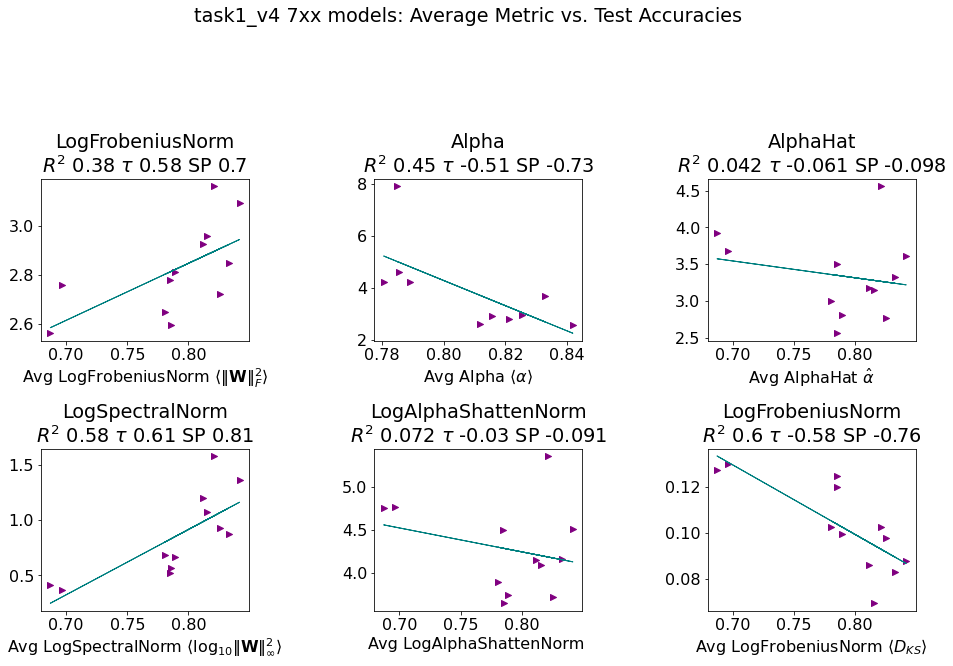

In [4]:
this_task = "task1_v4"
these_details = U.read_details(this_task)
task1_errors = plot_model_details(this_task, these_details)

#### Task2 Model Group Plots


Read 54 details dataframes for task2_v1


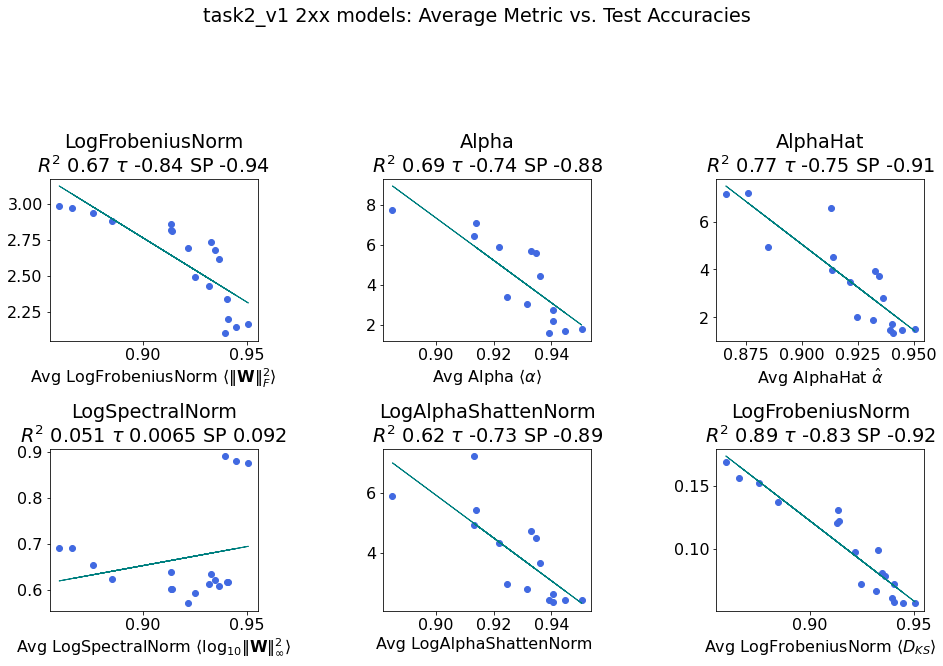

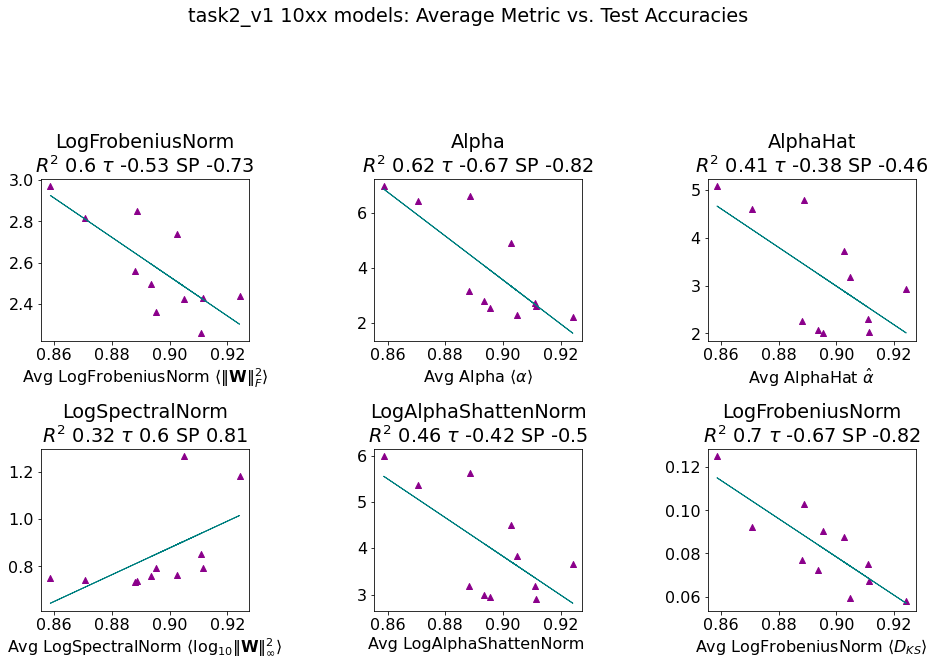

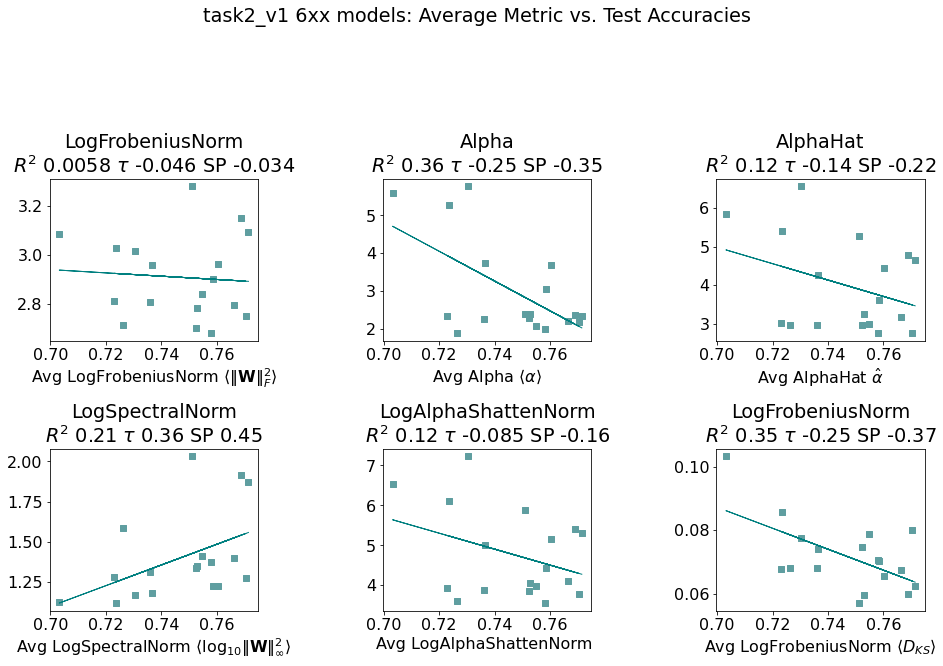

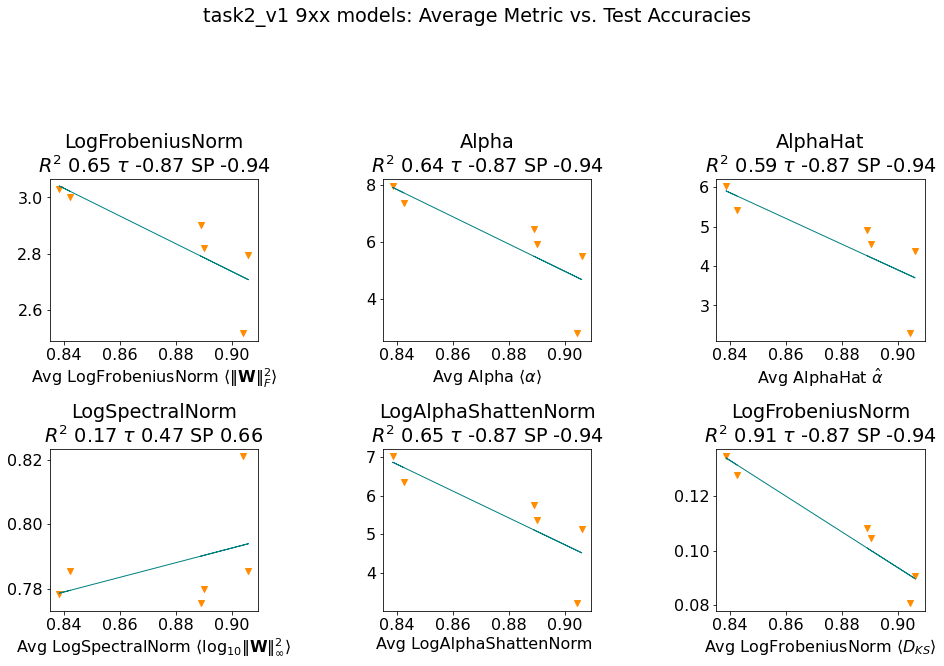

In [5]:
this_task = "task2_v1"
these_details = U.read_details(this_task)
task2_errors = plot_model_details(this_task, these_details)

### Simpsons Paradox Plot

Here are some plots showing how Simpsons Paradox applues to these models

In [6]:


def simpsons_plot(this_task, all_details, metric='logspectralnorm', eqn=None):
    
    results = {}
    results[this_task] = {'R2':{}, 'Ktau':{}}

    mids = set([100*U.model_num(k) for k in all_details.keys()])

    all_x, all_y = [], []
    for mid in mids:

        x, y = [], []

        legend=False
        for model, details in all_details.items():
            # remove first and last layers / min_size = 20 really
            details = details[details['N']> 10]
            details = details[details['M']> 10]

            xval = details[metric].dropna().mean()

            if xval < 8:
                this_mid = model.replace("model_", '')
                test_accuracy = test_accuracies[this_task][int(this_mid)]

                if int(this_mid) > mid and int(this_mid) < mid+100 :
                    y.append(test_accuracy)
                    x.append(xval)
                    color = U.mid_color(this_task, mid)
                    shape = U.mid_shape(this_task, mid)
                    model_num = U.model_num(mid)
                    if not legend:  
                        plt.scatter(xval, test_accuracy, label="{}xx".format(model_num),  color=color, marker=shape)
                        legend = True
                    else:
                        plt.scatter(xval, test_accuracy,  color=color, marker=shape)


        if len(x)>0:
            all_x.extend(x)
            all_y.extend(y)
            
            x = np.array(x).reshape(-1,1)
            y = np.array(y).reshape(-1,1)
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            y_pred = regr.predict(x)
            color = U.mid_color(this_task,mid)
            model_num = U.model_num(mid)
            plt.plot(x, y_pred, color=color, linewidth=1)
            
            R2 = r2_score(y, y_pred)
            tau, p_value = stats.kendalltau(x, y)
            print("{}xx & {:0.2} & {:0.2} \\\\".format(model_num, R2, tau))

            key = "{}xx".format(model_num)
            results[this_task]['R2'][key] = R2
            results[this_task]['Ktau'][key] = tau
            
            
    metname = U.metric_name(metric) 
    if eqn is None:
        meteqn = U.metric_eqn(metric)
        
    x = np.array(all_x).reshape(-1,1)
    y = np.array(all_y).reshape(-1,1)
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    plt.plot(x, y_pred, color=U.AVG_COLOR, linewidth=0.5, linestyle='-')
    
    
    R2 = r2_score(y, y_pred)
    tau, p_value = stats.kendalltau(x, y)
    print("all & {:0.2} & {:0.2} \\\\".format(R2, tau))
            
    taskname = U.taskname(this_task)

    #plt.title(r"{}: Simpsons Plot for {} ".format(this_task,meteqn))
    plt.title(r"Simpsons Plot for {} ".format(taskname,metname),  fontsize=U.TITLE_SIZE)
    plt.ylabel("Test Accuracy", fontsize=U.AXIS_SIZE)
    plt.xlabel(r"Avg {} {}".format(metname,meteqn),  fontsize=U.AXIS_SIZE)
    
    from matplotlib.ticker import StrMethodFormatter
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    plt.tick_params(axis='both', which='major', labelsize=U.TICK_SIZE)
    
    # add legend path for All plot
    import matplotlib.patches as mpatches
    handles, labels = plt.gca().get_legend_handles_labels()
    patch = mpatches.Patch(color=U.AVG_COLOR, label='All', fill=True, alpha=0.4)# hatch='-')
    handles.append(patch) 
    plt.legend(handles=handles, prop={'size': U.LEGEND_SIZE})#, loc='upper right')

    filename = "{}/simpsons-{}-{}.png".format(U.IMG_DIR, taskname, metname)
    plt.savefig(filename)
    plt.show()
    
    return results

Read 96 details dataframes for task1_v4
0xx & 0.34 & 0.41 \\


1xx & 0.68 & 0.73 \\
2xx & 0.59 & 0.73 \\


5xx & 0.58 & 0.6 \\
6xx & 0.22 & 0.59 \\


7xx & 0.58 & 0.61 \\
all & 0.1 & 0.28 \\


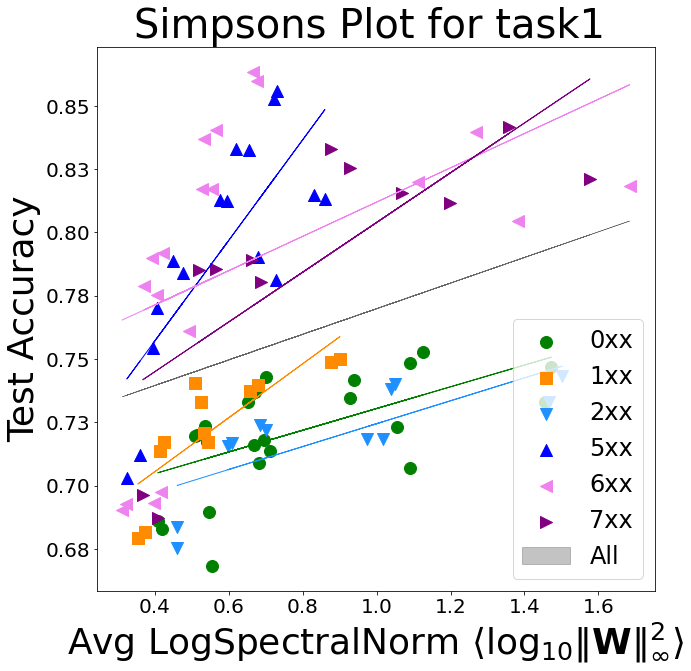

In [7]:
rcParams['figure.figsize'] = 10,10
#rcParams.update({'font.size': 26})

rcParams['lines.markersize'] = U.MARKER_SIZE

this_task = "task1_v4"
these_details = U.read_details(this_task)
logsp_results = simpsons_plot(this_task, these_details)

Read 54 details dataframes for task2_v1
2xx & 0.051 & 0.0065 \\
10xx & 0.32 & 0.6 \\


6xx & 0.21 & 0.36 \\
9xx & 0.17 & 0.47 \\
all & 0.59 & -0.43 \\


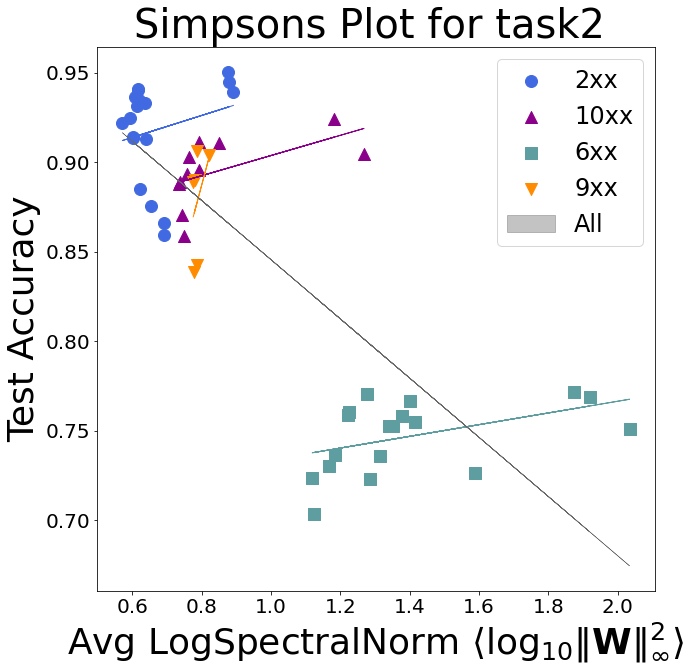

In [8]:
this_task = "task2_v1"
these_details =U.read_details(this_task)
results = simpsons_plot(this_task, these_details)
logsp_results.update(results)

Read 96 details dataframes for task1_v4
0xx & 0.55 & -0.55 \\


1xx & 0.88 & -0.48 \\
2xx & 0.69 & -0.52 \\


5xx & 0.086 & -0.1 \\
6xx & 0.67 & -0.32 \\


7xx & 0.45 & -0.51 \\
all & 0.13 & -0.29 \\


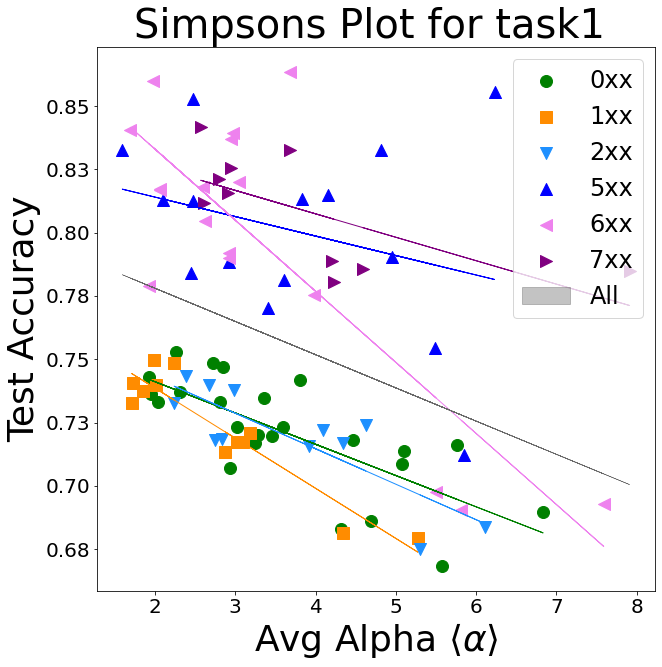

In [9]:


this_task = "task1_v4"
these_details = U.read_details(this_task)
alpha_results =  simpsons_plot(this_task, these_details, metric='alpha')

Read 54 details dataframes for task2_v1
2xx & 0.69 & -0.74 \\
10xx & 0.62 & -0.67 \\


6xx & 0.36 & -0.25 \\
9xx & 0.64 & -0.87 \\
all & 0.028 & -0.02 \\


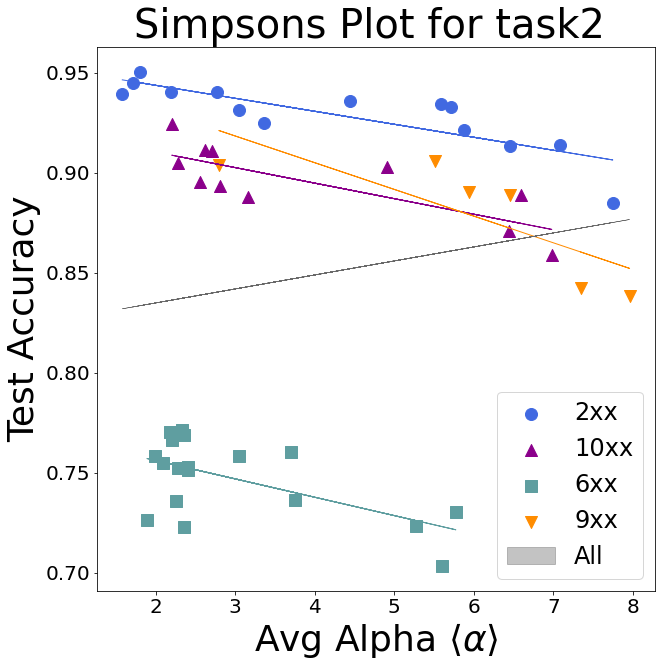

In [10]:
this_task = "task2_v1"
these_details = U.read_details(this_task)
results = simpsons_plot(this_task, these_details, metric='alpha')
alpha_results.update(results)

Read 96 details dataframes for task1_v4
0xx & 0.00033 & -0.062 \\


1xx & 0.0062 & 0.0 \\
2xx & 0.49 & 0.7 \\
5xx & 0.012 & 0.1 \\


6xx & 0.0033 & -0.041 \\
7xx & 0.042 & -0.061 \\
all & 0.00032 & -0.015 \\


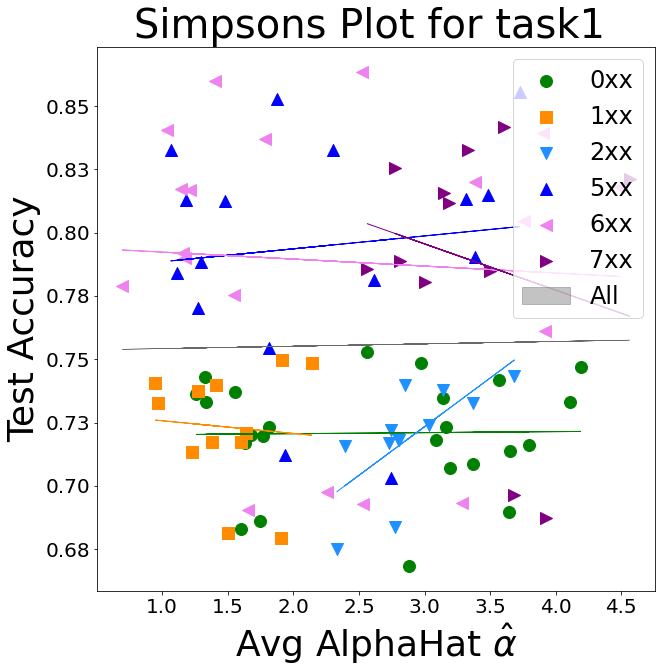

In [11]:

this_task = "task1_v4"
these_details = U.read_details(this_task)
alpha_weighted_results = simpsons_plot(this_task, these_details, metric='alpha_weighted')

Read 54 details dataframes for task2_v1
2xx & 0.77 & -0.75 \\
10xx & 0.41 & -0.38 \\


6xx & 0.12 & -0.14 \\
9xx & 0.59 & -0.87 \\
all & 0.1 & -0.34 \\


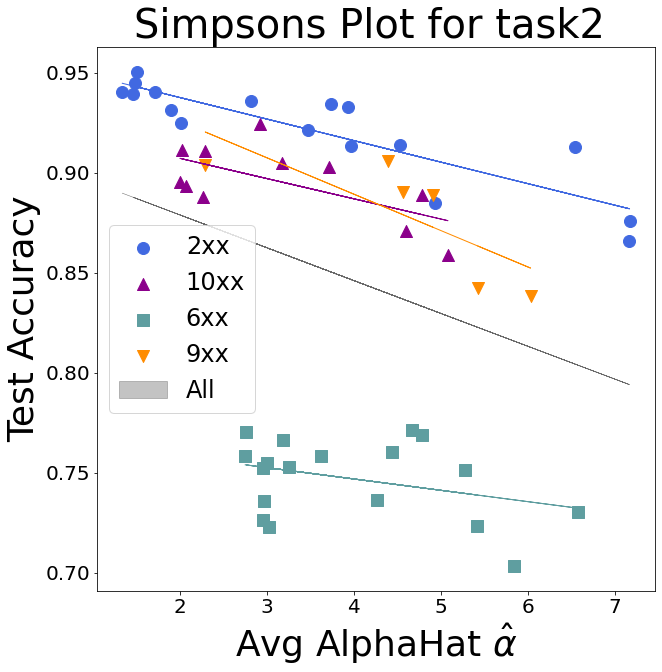

In [12]:
this_task = "task2_v1"
these_details = U.read_details(this_task)
alpha_weighted_results = simpsons_plot(this_task, these_details, metric='alpha_weighted')

### Bar Plots

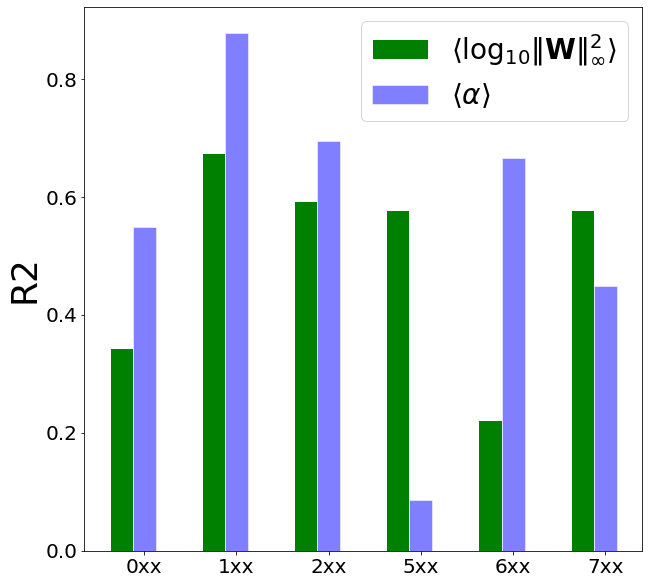

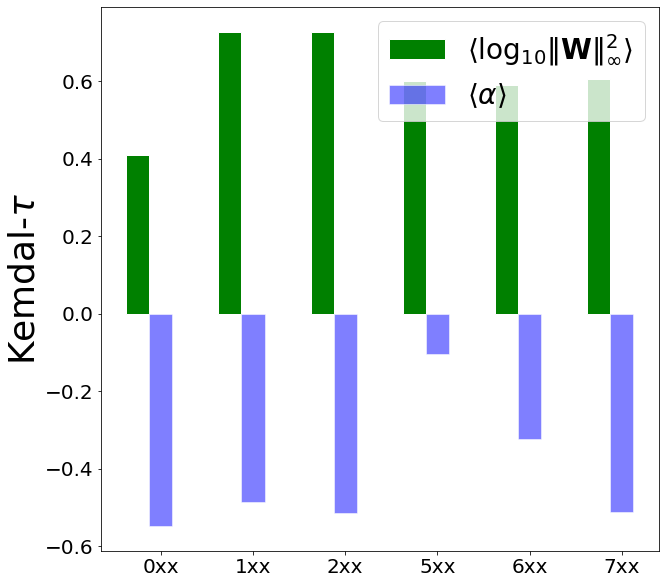

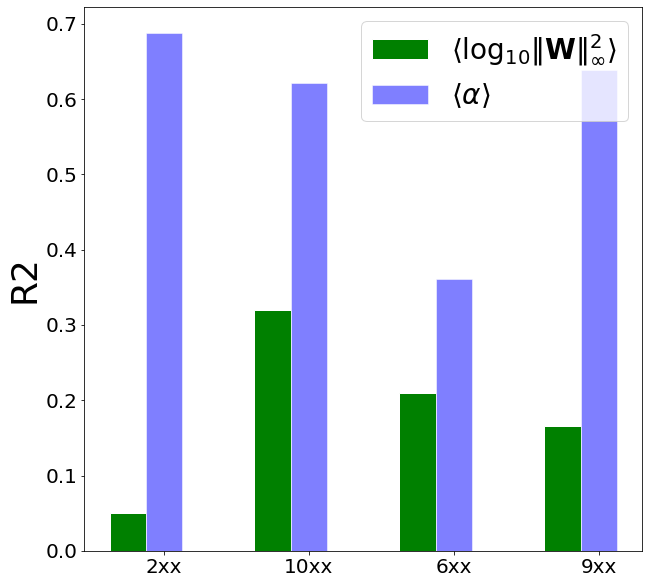

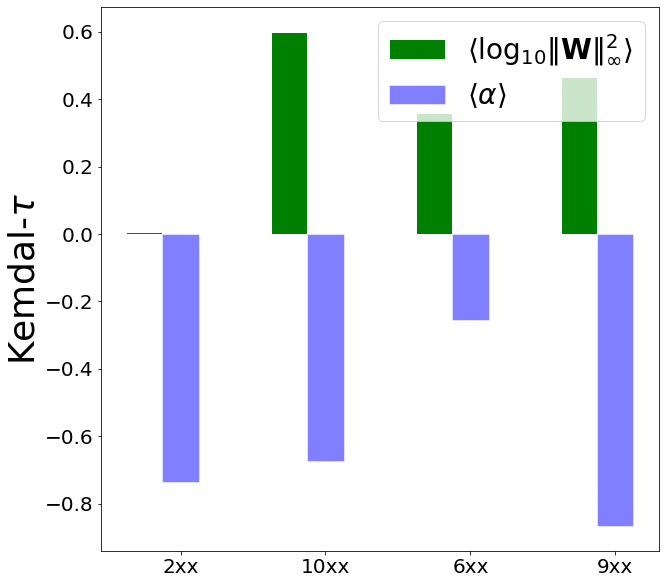

In [13]:
for task in ["task1_v4", "task2_v1"]:

    for metric, metname in zip(["R2", "Ktau"], [U.R_SQUARED, U.KENDAL_TAU]):
        
        metname = U.metric_name(metric) 
        
        #title = "{} for Regression on Test Accuracies for {} \n".format(metname, task)
        title = "{} for Regression on Test Accuracies \n".format(metname)
        title += U.ALPHA +" "+U.AVG_ALPHA_EQN+" and "+U.LOG_SPECTRALNORM+" "+U.AVG_LOG_SPECTRALNORM_EQN

        alpha = alpha_results[task][metric]
        logsp = logsp_results[task][metric]

        barWidth = 0.25

        bars = alpha.keys()
        r1 = np.arange(len(bars))
        r2 = [x + barWidth for x in r1]

        plt.bar(r1, logsp.values(), label=U.AVG_LOG_SPECTRALNORM_EQN, color='green',width=barWidth, edgecolor='white')
        plt.bar(r2, alpha.values(), label=U.AVG_ALPHA_EQN, alpha=0.5, color='blue',width=barWidth, edgecolor='white')
        plt.xticks([r + barWidth for r in range(len(bars))], bars)
        plt.tick_params(axis='both', which='major', labelsize=U.TICK_SIZE)

        plt.legend(prop={'size': U.LEGEND_SIZE+4}, loc='upper right')
        if metname=='Ktau':
            metname = r"Kemdal-$\tau$"
        plt.ylabel(metname, fontsize=U.AXIS_SIZE);
        #plt.title(title, fontsize=U.TITLE_SIZE)
        plt.savefig("{}/alpha-spnorm-{}-test-accs-{}".format(U.IMG_DIR, metric, task))
        plt.show()

### Table 6

### Compare log spectral norm to alpha for each model group

In [14]:
def compare_metrics_plot(this_task, all_details):
    """Compare log spectral norm to alpha for each model group"""
    
    results = {'R2':{}, 'Ktau':{}}
    
    mids = set([100*U.model_num(k) for k in all_details.keys()])

    for mid in mids:

        x, y = [], []

        legend=False
        for model, details in all_details.items():
            # remove first and last layers / min_size = 20 really
            details = details[details['N']> 10]
            details = details[details['M']> 10]

            xlabel=r"Avg LogSpectralNorm "+U.AVG_LOG_SPECTRALNORM_EQN
            xval = details['logspectralnorm'].dropna().mean()
            
            ylabel="Avg Alpha "+U.AVG_ALPHA_EQN
            yval = details['alpha'].dropna().mean()
                
            this_mid = model.replace("model_", '')
            if int(this_mid) > mid and int(this_mid) < mid+100 :
                x.append(xval)
                y.append(yval)

                    
        if len(x)>0:
            x = np.array(x)
            y = np.array(y)
            p = x.argsort()     
            x = x[p].reshape(-1,1)
            y = y[p].reshape(-1,1)
            color = U.mid_color(this_task, mid)
            shape = U.mid_shape(this_task, mid)
            model_num = U.model_num(mid)
            plt.scatter(x, y, label="{}xx".format(model_num), color=color, marker=shape)
                  
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            y_pred = regr.predict(x)
            plt.plot(x, y_pred,  linewidth=1 ,color=color)
            
             # table 3
            R2 = r2_score(y, y_pred)
            tau, p_value = stats.kendalltau(x, y)
            print("{}xx & {:0.2} & {:0.2} \\\\".format(model_num, R2, tau))

            key = "{}xx".format(model_num)
            results['R2'][key] = R2
            results['Ktau'][key] = tau
        
        title =  "Avg Alpha "+U.AVG_ALPHA_EQN+" vs. \n Avg LogSpectralNorm "+U.AVG_LOG_SPECTRALNORM_EQN
        title =  "Alpha vs. LogSpectralNorm "

        # removed for paper
        plt.title(title, fontsize=U.TITLE_SIZE)
        plt.xlabel(xlabel, fontsize=U.AXIS_SIZE)
        plt.ylabel(ylabel, fontsize=U.AXIS_SIZE)
        plt.legend(prop={'size': U.LEGEND_SIZE})#,loc='upper right')
        
        plt.tick_params(axis='both', which='major', labelsize=U.TICK_SIZE)
                  
        taskname = U.taskname(this_task)
        model_num = U.model_num(mid)
        filename = "{}/alpha-vs-spnorm-{}-{}xx.png".format(U.IMG_DIR,taskname,model_num)
        plt.savefig(filename)
        plt.show()


    return results

In [15]:
def combine_metrics_plot(this_task, all_details):
    """Compare log spectral norm to alpha for each model group, all together
    Also prints results for appendix table3"""
     
    results = {'R2':{}, 'Ktau':{}}
    
    mids = set([100*U.model_num(k) for k in all_details.keys()])

    for mid in mids:

        x, y = [], []

        legend=False
        for model, details in all_details.items():
            # remove first and last layers / min_size = 20 really
            details = details[details['N']> 10]
            details = details[details['M']> 10]

            xlabel=r"Avg LogSpectralNorm "+U.AVG_LOG_SPECTRALNORM_EQN
            xval = details['logspectralnorm'].dropna().mean()
            
            ylabel="Avg Alpha "+U.AVG_ALPHA_EQN
            yval = details['alpha'].dropna().mean()
                
            this_mid = model.replace("model_", '')
            if int(this_mid) > mid and int(this_mid) < mid+100 :
                x.append(xval)
                y.append(yval)

                    
        if len(x)>0:
            x = np.array(x)
            y = np.array(y)
            p = x.argsort()     
            x = x[p].reshape(-1,1)
            y = y[p].reshape(-1,1)
            color = U.mid_color(this_task, mid)
            shape = U.mid_shape(this_task, mid)
            model_num = U.model_num(mid)
            plt.scatter(x, y, label="{}xx".format(model_num), color=color, marker=shape)
                  
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            y_pred = regr.predict(x)
            plt.plot(x, y_pred,  linewidth=1 ,color=color)
            
             # table 3
            R2 = r2_score(y, y_pred)
            tau, p_value = stats.kendalltau(x, y)
            print("{}xx & {:0.2} & {:0.2} \\\\".format(model_num, R2, tau))

            key = "{}xx".format(model_num)
            results['R2'][key] = R2
            results['Ktau'][key] = tau
            
    results['R2']['AVG'] = np.mean([x for x in results['R2'].values()])
    results['Ktau']['AVG'] = np.mean([x for x in results['Ktau'].values()])
    print("{} & {:0.2} & {:0.2} \\\\".format('AVG',  results['R2']['AVG'], results['Ktau']['AVG']))
        
    title =  "Avg Alpha "+U.AVG_ALPHA_EQN+" vs. \n Avg LogSpectralNorm "+U.AVG_LOG_SPECTRALNORM_EQN
    title =  "Alpha vs. LogSpectralNorm "

    # removed for paper
    plt.title(title, fontsize=U.TITLE_SIZE)
    plt.xlabel(xlabel, fontsize=U.AXIS_SIZE)
    plt.ylabel(ylabel, fontsize=U.AXIS_SIZE)
    plt.legend(prop={'size': U.LEGEND_SIZE})#,loc='upper right')

    plt.tick_params(axis='both', which='major', labelsize=U.TICK_SIZE)

    taskname = U.taskname(this_task)
    model_num = U.model_num(mid)
    filename = "{}/alpha-vs-spnorm-{}.png".format(U.IMG_DIR,taskname)
    plt.savefig(filename)
    plt.show()

 
    
    return results

Read 96 details dataframes for task1_v4
0xx & 0.16 & -0.29 \\


1xx & 0.41 & -0.39 \\
2xx & 0.8 & -0.79 \\


5xx & 0.12 & -0.12 \\
6xx & 0.12 & -0.26 \\
7xx & 0.64 & -0.91 \\
AVG & 0.38 & -0.46 \\


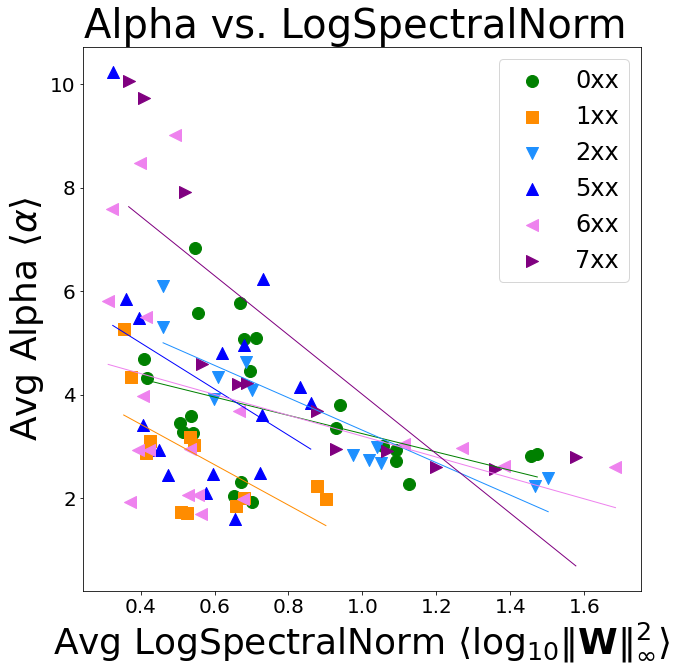

In [16]:
this_task = "task1_v4"
these_details = U.read_details(this_task)
task1_results = combine_metrics_plot(this_task, these_details)

Read 54 details dataframes for task2_v1
2xx & 0.11 & -0.033 \\
10xx & 0.27 & -0.64 \\
6xx & 0.28 & -0.45 \\
9xx & 0.75 & -0.6 \\
AVG & 0.36 & -0.43 \\


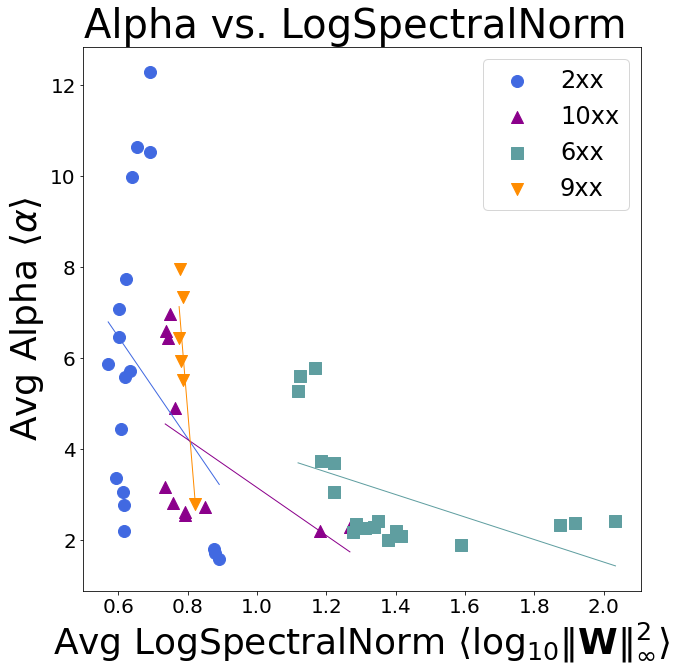

In [17]:
this_task = "task2_v1"
these_details = U.read_details(this_task)
task2_results = combine_metrics_plot(this_task, these_details)


Read 96 details dataframes for task1_v4
0xx & 0.16 & -0.29 \\


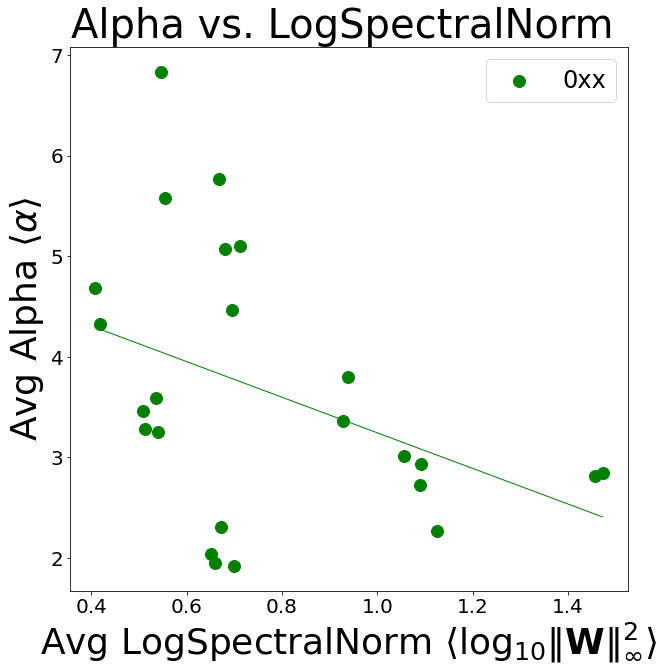

1xx & 0.41 & -0.39 \\


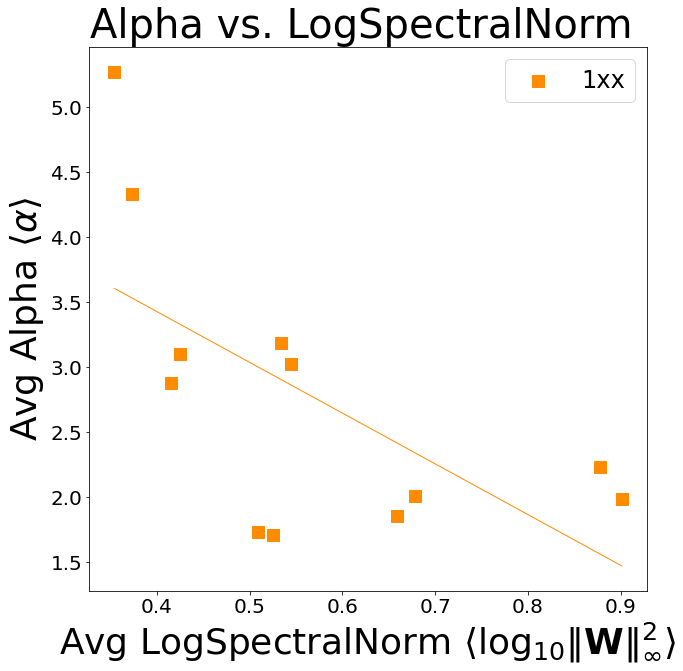

2xx & 0.8 & -0.79 \\


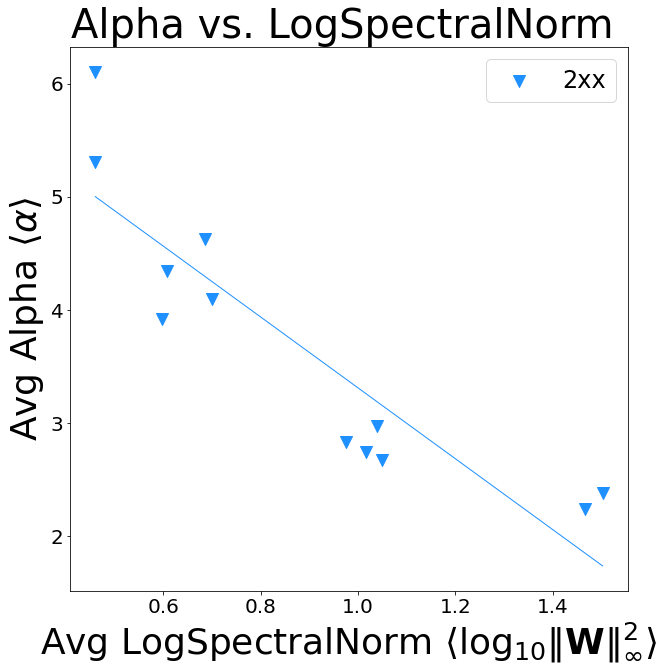

5xx & 0.12 & -0.12 \\


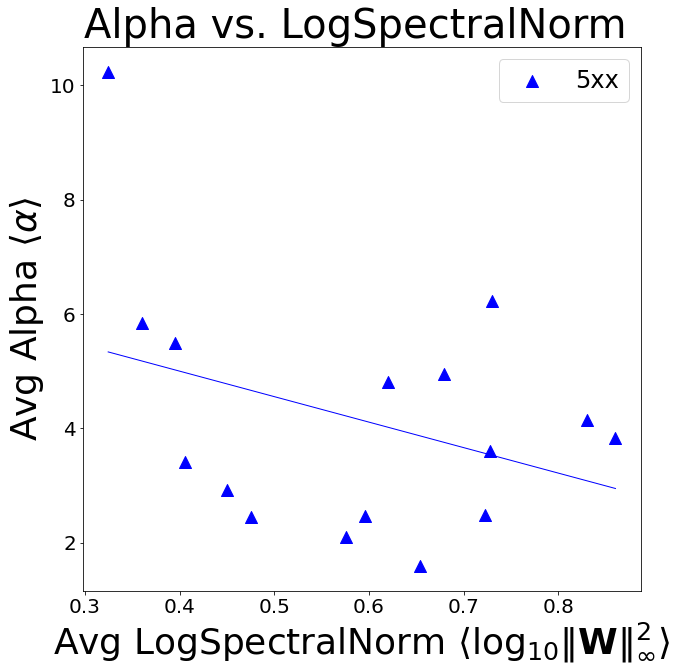

6xx & 0.12 & -0.26 \\


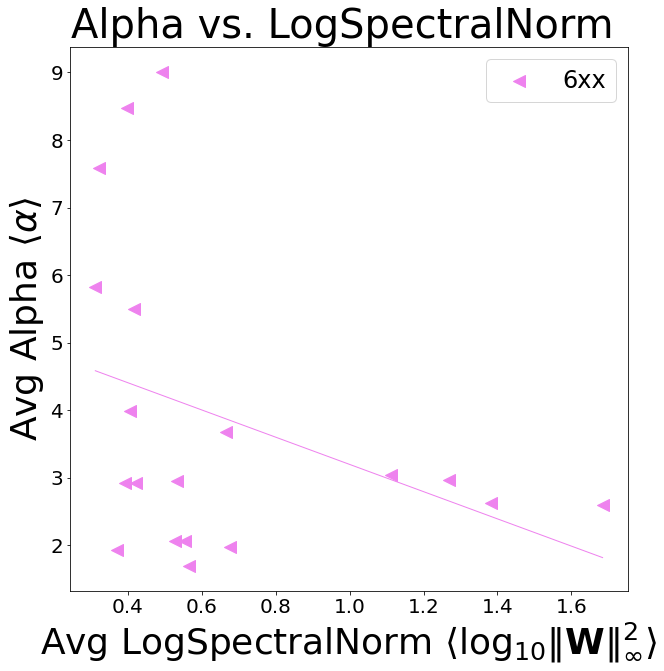

7xx & 0.64 & -0.91 \\


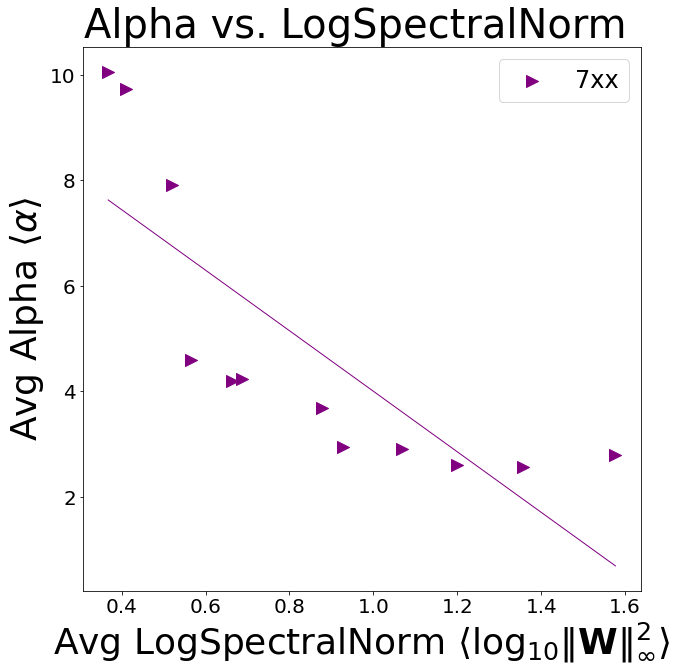

{'R2': {'0xx': 0.16197880571518208,
  '1xx': 0.40510608806260184,
  '2xx': 0.8033555767110726,
  '5xx': 0.12358019042786683,
  '6xx': 0.12436702240295072,
  '7xx': 0.6396054472006972},
 'Ktau': {'0xx': -0.28985507246376807,
  '1xx': -0.39393939393939387,
  '2xx': -0.7878787878787877,
  '5xx': -0.11666666666666665,
  '6xx': -0.2631578947368421,
  '7xx': -0.909090909090909}}

In [18]:
this_task = "task1_v4"
these_details = U.read_details(this_task)
compare_metrics_plot(this_task, these_details)


Read 54 details dataframes for task2_v1
2xx & 0.11 & -0.033 \\


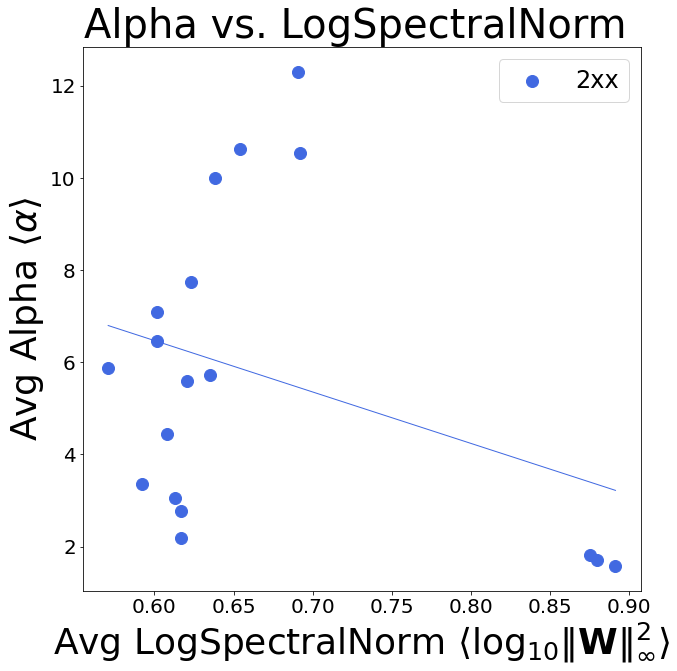

10xx & 0.27 & -0.64 \\


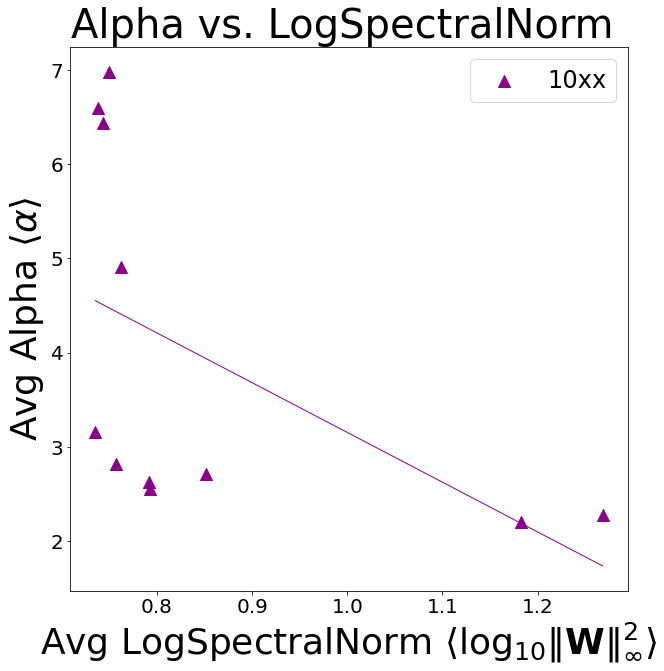

6xx & 0.28 & -0.45 \\


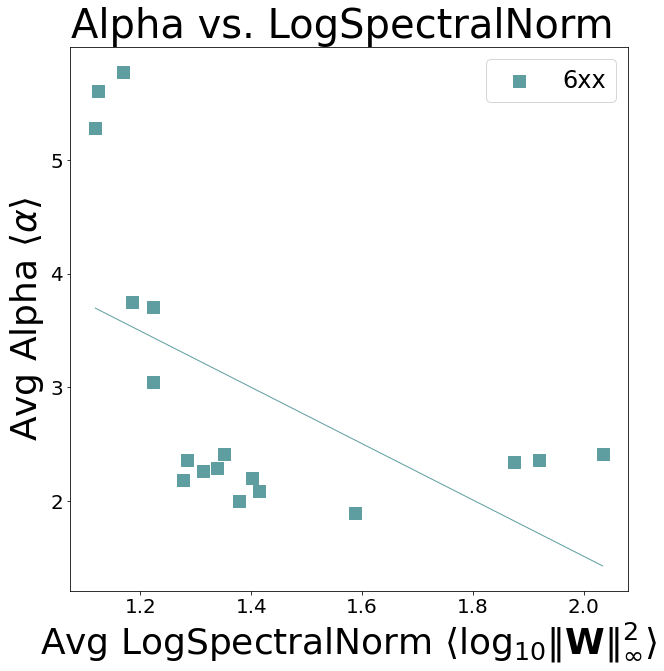

9xx & 0.75 & -0.6 \\


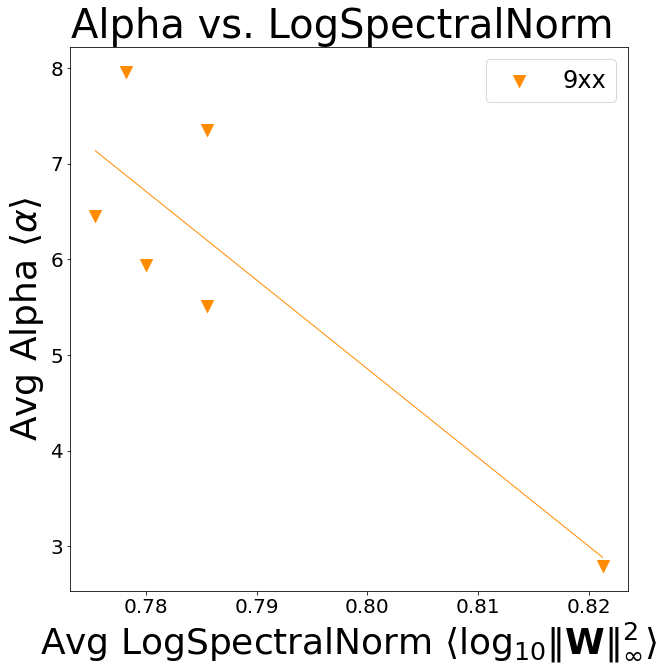

{'R2': {'2xx': 0.11303373315882514,
  '10xx': 0.2731476281435328,
  '6xx': 0.28233545507273616,
  '9xx': 0.753921438401027},
 'Ktau': {'2xx': -0.032679738562091505,
  '10xx': -0.6363636363636364,
  '6xx': -0.4509803921568628,
  '9xx': -0.6}}

In [19]:
this_task = "task2_v1"
these_details = U.read_details(this_task)
compare_metrics_plot(this_task, these_details)

# Table 4

In [20]:
def melted_df(errors, metric, task=1):
    if task==1:
        cols = { 0:'0xx', 100:'1xx', 200:'2xx', 500:'5xx', 600:'6xx', 700:'7xx'}
    else:
        cols = { 200:'2xx', 600:'6xx', 900:'9xx', 1000:'10xx'}        

    df = pd.DataFrame(errors)

    df = df.rename(columns=cols)
    for col in cols.values():
        df[col]=df[col].apply(lambda x: x[metric])
    df = df.reset_index()
    df = df.rename(columns={'index':'metric'})
    mdf = df.melt('metric')
    mdf.rename(columns={'variable':'model', 'value':metric}, inplace=True)
    return mdf

In [21]:
df1_kt = melted_df(task1_errors, 'kendal_tau', task=1)
df1_r2 = melted_df(task1_errors, 'R2', task=1)
df2_kt = melted_df(task2_errors, 'kendal_tau', task=2)
df2_r2 = melted_df(task2_errors, 'R2', task=2)
table4_df1 = pd.merge(df1_kt,df1_r2)
table4_df2 = pd.merge(df2_kt,df2_r2)

In [22]:
def add_avg_metric(df):
    all_R2 = df.groupby('metric')['R2'].apply(np.average).to_frame()
    all_Kt = df.groupby('metric')['kendal_tau'].apply(np.average).to_frame()
    all_df = all_R2.join(all_Kt)
    all_df['model']='AVG'
    all_df.reset_index(inplace=True)
    return pd.concat([df, all_df])

In [23]:
table4_df1 = add_avg_metric(table4_df1)
table4_df2 = add_avg_metric(table4_df2)
table4_dfs= [table4_df1, table4_df2]

In [24]:


metrics = ['logspectralnorm','lognorm', 'alpha', 'D']
measures = ['R2', 'kendal_tau']
tasks = ['\TASKONE', '\TASKTWO']

HEADER = """
\\begin{tabular}{|p{1.05in}|c|c|c|c|c|c|c|c|c|c|}
\hline
& \multicolumn{2}{|c|}{ \SPECTRALNORM      } 
& \multicolumn{2}{|c|}{ \FROBENIUSNORM     } 
& \multicolumn{2}{|c|}{ \ALPHA             } 
& \multicolumn{2}{|c|}{ \QUALITYOFALPHAFIT } 
\\\\
\hline
               &  $R^2$ & Kendal-$\\tau$ &  $R^2$ & Kendal-$\\tau$ &  $R^2$ & Kendal-$\\tau$ &  $R^2$ & Kendal-$\\tau$  \\\\
"""
    
with open('./table4.tex', 'w') as f:

    f.write(HEADER)
    for df, task in zip(table4_dfs,tasks):
        #print(task+" - ALL & XXX & XXX & XXX & XXX & XXX & XXX & XXX & XXX  \\\\")
        f.write("\\hline\n")
        mids = df.model.unique()
                
        for mid in mids:
            
            # bold the largest R2, KTau for each task
            R2s, KTs = [], []
            for metric in metrics:
                R2 = df[(df.model==mid) & (df.metric==metric) ]['R2'].to_numpy()[0]
                Ktau = df[(df.model==mid) & (df.metric==metric) ]['kendal_tau'].to_numpy()[0]
                R2s.append(R2)
                KTs.append(Ktau)
            max_r2_id = np.argmax(R2s)
            max_kt_id = np.argmax(np.abs(KTs))
            
            line = "{} - {} &".format(task,mid)
            for im, metric in enumerate(metrics):
                R2 = df[(df.model==mid) & (df.metric==metric) ]['R2'].to_numpy()[0]
                Ktau = df[(df.model==mid) & (df.metric==metric) ]['kendal_tau'].to_numpy()[0]
                R2_str = " {:0.2f} ".format(R2)
                Ktau_str = " {:0.2f} ".format(Ktau)
                if im==max_r2_id:
                    R2_str = "\\textbf{"+R2_str+"}"
                if im==max_kt_id:
                    Ktau_str = "\\textbf{"+Ktau_str+"}"
                    
                line = line + R2_str + " & "+ Ktau_str+ " &"
            f.write(line[:-1]+"\\\\\n")
            f.write("\hline\n")
            line = ""

        f.write(line)
    f.write("\end{tabular}\n")

In [25]:
!cp table4.tex ../paper

In [26]:
!cat table4.tex


\begin{tabular}{|p{1.05in}|c|c|c|c|c|c|c|c|c|c|}
\hline
& \multicolumn{2}{|c|}{ \SPECTRALNORM      } 
& \multicolumn{2}{|c|}{ \FROBENIUSNORM     } 
& \multicolumn{2}{|c|}{ \ALPHA             } 
& \multicolumn{2}{|c|}{ \QUALITYOFALPHAFIT } 
\\
\hline
               &  $R^2$ & Kendal-$\tau$ &  $R^2$ & Kendal-$\tau$ &  $R^2$ & Kendal-$\tau$ &  $R^2$ & Kendal-$\tau$  \\
\hline
\TASKONE - 0xx & 0.34  &  0.41  & 0.00  &  -0.03  &\textbf{ 0.55 } & \textbf{ -0.55 } & 0.02  &  -0.10  \\
\hline
\TASKONE - 1xx & 0.68  & \textbf{ 0.73 } & 0.29  &  -0.30  &\textbf{ 0.88 } &  -0.48  & 0.00  &  0.15  \\
\hline
\TASKONE - 2xx & 0.59  &  0.73  & 0.42  &  0.55  &\textbf{ 0.69 } &  -0.52  & 0.67  & \textbf{ -0.82 } \\
\hline
\TASKONE - 5xx &\textbf{ 0.58 } & \textbf{ 0.60 } & 0.19  &  -0.25  & 0.09  &  -0.10  & 0.04  &  0.18  \\
\hline
\TASKONE - 6xx & 0.22  & \textbf{ 0.59 } & 0.05  &  -0.10  &\textbf{ 0.67 } &  -0.32  & 0.10  &  -0.13  \\
\hline
\TASKONE - 7xx & 0.58  & \textbf{ 0.61 } & 0.38  &  0.58

In [27]:
#!cp ./img/*png ../paper/img2